In [1]:
import pandas as pd
import numpy as np
import mlflow
import dagshub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando dados de treino e teste
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

print(f"Dados de treino: {train_df.shape}")
print(f"Dados de teste: {test_df.shape}")

# Visualizando primeiras linhas
train_df.head()


Dados de treino: (69, 28)
Dados de teste: (29, 27)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,"0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"0x1603,CUS_0xd40,February,Aaron Maashoh,23,821...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Verificando informações gerais
print("Informações dos dados de treino:")
print(train_df.info())
print("\nValores únicos da variável alvo:")
print(train_df['Credit_Score'].value_counts())
print("\nDistribuição percentual:")
print(train_df['Credit_Score'].value_counts(normalize=True) * 100)


Informações dos dados de treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        69 non-null     object 
 1   Customer_ID               32 non-null     object 
 2   Month                     32 non-null     object 
 3   Name                      32 non-null     object 
 4   Age                       32 non-null     object 
 5   SSN                       32 non-null     object 
 6   Occupation                32 non-null     object 
 7   Annual_Income             32 non-null     object 
 8   Monthly_Inhand_Salary     27 non-null     float64
 9   Num_Bank_Accounts         32 non-null     float64
 10  Num_Credit_Card           32 non-null     float64
 11  Interest_Rate             32 non-null     float64
 12  Num_of_Loan               32 non-null     object 
 13  Type_of_Loan              16 non-n

In [4]:
# Verificando valores nulos
print("Valores nulos por coluna:")
print(train_df.isnull().sum())
print("\nPercentual de valores nulos:")
print((train_df.isnull().sum() / len(train_df)) * 100)


Valores nulos por coluna:
ID                           0
Customer_ID                 37
Month                       37
Name                        37
Age                         37
SSN                         37
Occupation                  37
Annual_Income               37
Monthly_Inhand_Salary       42
Num_Bank_Accounts           37
Num_Credit_Card             37
Interest_Rate               37
Num_of_Loan                 37
Type_of_Loan                53
Delay_from_due_date         37
Num_of_Delayed_Payment      40
Changed_Credit_Limit        37
Num_Credit_Inquiries        38
Credit_Mix                  37
Outstanding_Debt            37
Credit_Utilization_Ratio    37
Credit_History_Age          40
Payment_of_Min_Amount       37
Total_EMI_per_month         37
Amount_invested_monthly     37
Payment_Behaviour           37
Monthly_Balance             37
Credit_Score                37
dtype: int64

Percentual de valores nulos:
ID                           0.000000
Customer_ID              

In [5]:
# Pré-processamento dos Dados

def preprocess_data(df, is_training=True):
    """
    Função para pré-processar os dados de credit score
    """
    # Cópia do dataframe
    df_processed = df.copy()
    
    # Removendo colunas desnecessárias
    columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN']
    df_processed = df_processed.drop(columns=[col for col in columns_to_drop if col in df_processed.columns])
    
    # Tratamento de valores problemáticos em colunas numéricas
    numeric_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 
                      'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                      'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                      'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                      'Amount_invested_monthly', 'Monthly_Balance']
    
    for col in numeric_columns:
        if col in df_processed.columns:
            # Convertendo valores não numéricos para NaN
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            
            # Tratando outliers negativos para idade
            if col == 'Age':
                df_processed[col] = df_processed[col].apply(lambda x: np.nan if x < 0 or x > 100 else x)
    
    # Tratamento de valores categóricos problemáticos
    categorical_columns = ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 
                          'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']
    
    for col in categorical_columns:
        if col in df_processed.columns:
            # Substituindo valores problemáticos por NaN
            df_processed[col] = df_processed[col].replace(['_', '!@9#%8', '#F%$D@*&8', '_______', 'NA'], np.nan)
    
    return df_processed

# Aplicando pré-processamento
train_processed = preprocess_data(train_df, is_training=True)
test_processed = preprocess_data(test_df, is_training=False)

print("Dados após pré-processamento:")
print(f"Treino: {train_processed.shape}")
print(f"Teste: {test_processed.shape}")
print("\nValores nulos após limpeza:")
print(train_processed.isnull().sum())


Dados após pré-processamento:
Treino: (69, 24)
Teste: (29, 23)

Valores nulos após limpeza:
Month                       37
Age                         38
Occupation                  40
Annual_Income               40
Monthly_Inhand_Salary       42
Num_Bank_Accounts           37
Num_Credit_Card             37
Interest_Rate               37
Num_of_Loan                 38
Type_of_Loan                53
Delay_from_due_date         37
Num_of_Delayed_Payment      41
Changed_Credit_Limit        37
Num_Credit_Inquiries        38
Credit_Mix                  43
Outstanding_Debt            37
Credit_Utilization_Ratio    37
Credit_History_Age          40
Payment_of_Min_Amount       37
Total_EMI_per_month         37
Amount_invested_monthly     38
Payment_Behaviour           39
Monthly_Balance             37
Credit_Score                37
dtype: int64


In [8]:
# Separando features e target
features = list(train_processed.columns)
features.remove('Credit_Score')

# Removendo linhas com target NaN antes da separação
train_clean = train_processed.dropna(subset=['Credit_Score'])

X = train_clean[features]
y = train_clean['Credit_Score']

print(f"Dados após remover NaN do target: {train_clean.shape}")
print(f"Número de features: {len(features)}")
print(f"Features: {features}")
print(f"\nDistribuição da variável alvo:")
print(y.value_counts())

Dados após remover NaN do target: (32, 24)
Número de features: 23
Features: ['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']

Distribuição da variável alvo:
Credit_Score
Standard    19
Good        13
Name: count, dtype: int64


In [9]:
# Criando pipeline de pré-processamento
# Identificando colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")

# Pipeline de pré-processamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Verificando se y não contém valores NaN antes da divisão
print(f"\nValores NaN em y: {y.isna().sum()}")
print(f"Total de amostras: {len(y)}")

# Dividindo dados para treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTamanhos após divisão:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Features numéricas: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
Features categóricas: ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']

Valores NaN em y: 0
Total de amostras: 32

Tamanhos após divisão:
X_train: (22, 23), y_train: (22,)
X_val: (10, 23), y_val: (10,)


In [12]:
# Configuração do MLflow 
dagshub.init(repo_owner="domires", repo_name="fiap-mlops-score-model", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/domires/fiap-mlops-score-model.mlflow")


Initialized MLflow to track repo "domires/fiap-mlops-score-model"

Repository domires/fiap-mlops-score-model initialized!

In [16]:
# Função de Avaliação de Modelos (compatível com DagsHub)
def evaluate_and_log_classification_model(model_name, pipeline, X_val, y_val):
    """
    Função para avaliar e registrar modelo Random Forest de classificação
    Versão compatível com DagsHub - apenas métricas
    """
    # Fazendo predições
    predictions = pipeline.predict(X_val)
    prediction_proba = pipeline.predict_proba(X_val) if hasattr(pipeline, "predict_proba") else None
    
    # Calculando métricas
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='weighted')
    recall = recall_score(y_val, predictions, average='weighted')
    f1 = f1_score(y_val, predictions, average='weighted')
    
    # AUC-ROC para classificação multiclasse
    if prediction_proba is not None:
        try:
            auc_roc = roc_auc_score(y_val, prediction_proba, multi_class='ovr', average='weighted')
        except:
            auc_roc = 0.0
    else:
        auc_roc = 0.0
    
    # Registrando apenas métricas no MLflow (compatível com DagsHub)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", auc_roc)
    
    print(f"Modelo {model_name} avaliado:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc
    }

In [17]:
## Treinamento do Modelo Random Forest

with mlflow.start_run(run_name="Random Forest - Credit Score Classification"):
    # Criando pipeline com Random Forest usando parâmetros otimizados da referência
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=150,
            criterion='gini', 
            max_features='sqrt',
            random_state=42,
            max_depth=30,
            class_weight='balanced_subsample',
            min_samples_split=2,
            min_samples_leaf=1
        ))
    ])
    
    # Registrando parâmetros do modelo fixo
    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("criterion", "gini")
    mlflow.log_param("max_features", "sqrt")
    mlflow.log_param("max_depth", 30)
    mlflow.log_param("class_weight", "balanced_subsample")
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("random_state", 42)
    
    print("Treinando modelo Random Forest com parâmetros otimizados...")
    final_model.fit(X_train, y_train)
    
    # Avaliando modelo
    print("\nAvaliando modelo Random Forest...")
    metrics = evaluate_and_log_classification_model("random_forest_credit_score", final_model, X_val, y_val)
    
    print(f"\nModelo Random Forest treinado com sucesso!")
    print(f"Acurácia de validação: {metrics['accuracy']:.4f}")

Treinando modelo Random Forest com parâmetros otimizados...

Avaliando modelo Random Forest...
Modelo random_forest_credit_score avaliado:
Accuracy: 0.8000
Precision: 0.8667
Recall: 0.8000
F1-Score: 0.8000
AUC-ROC: 0.0000

Modelo Random Forest treinado com sucesso!
Acurácia de validação: 0.8000
🏃 View run Random Forest - Credit Score Classification at: https://dagshub.com/domires/fiap-mlops-score-model.mlflow/#/experiments/0/runs/ca93121255f44a51abfb778377d5f089
🧪 View experiment at: https://dagshub.com/domires/fiap-mlops-score-model.mlflow/#/experiments/0


In [18]:
# Preparando dados de teste para predição
if 'Credit_Score' in test_processed.columns:
    # Se o conjunto de teste tiver a variável alvo (para avaliação)
    X_test = test_processed[features]
    y_test = test_processed['Credit_Score']
    
    # Fazendo predições no conjunto de teste
    test_predictions = final_model.predict(X_test)
    test_probabilities = final_model.predict_proba(X_test)
    
    # Avaliando no conjunto de teste
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions, average='weighted')
    test_recall = recall_score(y_test, test_predictions, average='weighted')
    test_f1 = f1_score(y_test, test_predictions, average='weighted')
    
    print("RESULTADOS NO CONJUNTO DE TESTE")
    print(f"Acurácia: {test_accuracy:.4f}")
    print(f"Precisão: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    
    # Matriz de confusão
    from sklearn.metrics import classification_report
    print("\nRelatório de classificação:")
    print(classification_report(y_test, test_predictions))
    
else:
    # Se não houver variável alvo no teste, apenas fazer predições
    X_test = test_processed[features]
    test_predictions = final_model.predict(X_test)
    test_probabilities = final_model.predict_proba(X_test)
    
    print("Predições realizadas no conjunto de teste.")
    print(f"Distribuição das predições:")
    unique, counts = np.unique(test_predictions, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  {label}: {count} ({count/len(test_predictions)*100:.1f}%)")

# Salvando predições
predictions_df = pd.DataFrame({
    'prediction': test_predictions
})

# Adicionando probabilidades se disponível
if test_probabilities is not None:
    prob_columns = [f'prob_class_{i}' for i in range(test_probabilities.shape[1])]
    prob_df = pd.DataFrame(test_probabilities, columns=prob_columns)
    predictions_df = pd.concat([predictions_df, prob_df], axis=1)

print(f"\nPrimeiras 10 predições:")
print(predictions_df.head(10))

Predições realizadas no conjunto de teste.
Distribuição das predições:
  Good: 8 (27.6%)
  Standard: 21 (72.4%)

Primeiras 10 predições:
  prediction  prob_class_0  prob_class_1
0   Standard      0.126667      0.873333
1   Standard      0.126667      0.873333
2   Standard      0.126667      0.873333
3   Standard      0.126667      0.873333
4       Good      0.520000      0.480000
5       Good      0.773333      0.226667
6       Good      0.793333      0.206667
7       Good      0.813333      0.186667
8   Standard      0.126667      0.873333
9   Standard      0.126667      0.873333


In [19]:
# Salvando o modelo treinado localmente
import joblib
import os

# Criando diretório para modelos se não existir
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Salvando o modelo final
model_path = os.path.join(models_dir, 'fiap-mlops-score-model.pkl')
joblib.dump(final_model, model_path)

print(f"Modelo Random Forest salvo em: {model_path}")

# Salvando também as predições
predictions_path = os.path.join(models_dir, 'test_predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

print(f"Predições salvas em: {predictions_path}")

# Salvando informações do modelo
model_info = {
    'model_type': 'RandomForestClassifier',
    'features': features,
    'validation_metrics': metrics,
    'model_params': final_model.named_steps['classifier'].get_params()
}

import json
info_path = os.path.join(models_dir, 'model_info.json')
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2, default=str)

print(f"Informações do modelo salvas em: {info_path}")
print("\nRESUMO DO MODELO FINAL")
print(f"Número de features: {len(features)}")
print(f"Métricas de validação:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

Modelo Random Forest salvo em: ../models\fiap-mlops-score-model.pkl
Predições salvas em: ../models\test_predictions.csv
Informações do modelo salvas em: ../models\model_info.json

RESUMO DO MODELO FINAL
Número de features: 23
Métricas de validação:
  accuracy: 0.8000
  precision: 0.8667
  recall: 0.8000
  f1_score: 0.8000
  auc_roc: 0.0000


In [20]:
# Tentativa alternativa de salvar modelo no MLflow como artifact (compatível com DagsHub)
try:
    import tempfile
    import os
    
    # Criar arquivo temporário para o modelo
    with tempfile.NamedTemporaryFile(delete=False, suffix='.pkl') as tmp_file:
        joblib.dump(final_model, tmp_file.name)
        
        # Tentar fazer upload como artifact
        mlflow.log_artifact(tmp_file.name, "model")
        print("Modelo salvo como artifact no MLflow!")
        
    # Limpar arquivo temporário
    os.unlink(tmp_file.name)
    
except Exception as e:
    print(f"Erro ao salvar como artifact: {e}")
    print("Modelo disponível apenas localmente.")


Modelo salvo como artifact no MLflow!


In [21]:
# Verificando experimentos registrados no MLflow
print("VERIFICAÇÃO DE EXPERIMENTOS NO MLFLOW")
try:
    # Listando os últimos experimentos
    experiments = mlflow.search_experiments()
    if experiments:
        latest_exp = experiments[0]
        print(f"Experimento atual: {latest_exp.name}")
        
        # Listando as runs mais recentes
        runs = mlflow.search_runs(experiment_ids=[latest_exp.experiment_id], max_results=5)
        print(f"\nÚltimas {len(runs)} execuções:")
        for i, run in runs.iterrows():
            print(f"  - {run['tags.mlflow.runName']} (Status: {run['status']})")
    
    print(f"\nApenas 1 modelo Random Forest foi treinado nesta execução!")
    
except Exception as e:
    print(f"Não foi possível listar experimentos: {e}")
    print("Mas apenas 1 modelo Random Forest foi treinado!")


VERIFICAÇÃO DE EXPERIMENTOS NO MLFLOW
Experimento atual: Default

Últimas 5 execuções:
  - orderly-rook-127 (Status: RUNNING)
  - Random Forest - Credit Score Classification (Status: FINISHED)
  - Random Forest - Credit Score Classification (Status: FAILED)
  - CORRECAO-fiap-mlops-score-model (Status: FINISHED)
  - fiap-mlops-score-model-final (Status: FINISHED)

Apenas 1 modelo Random Forest foi treinado nesta execução!


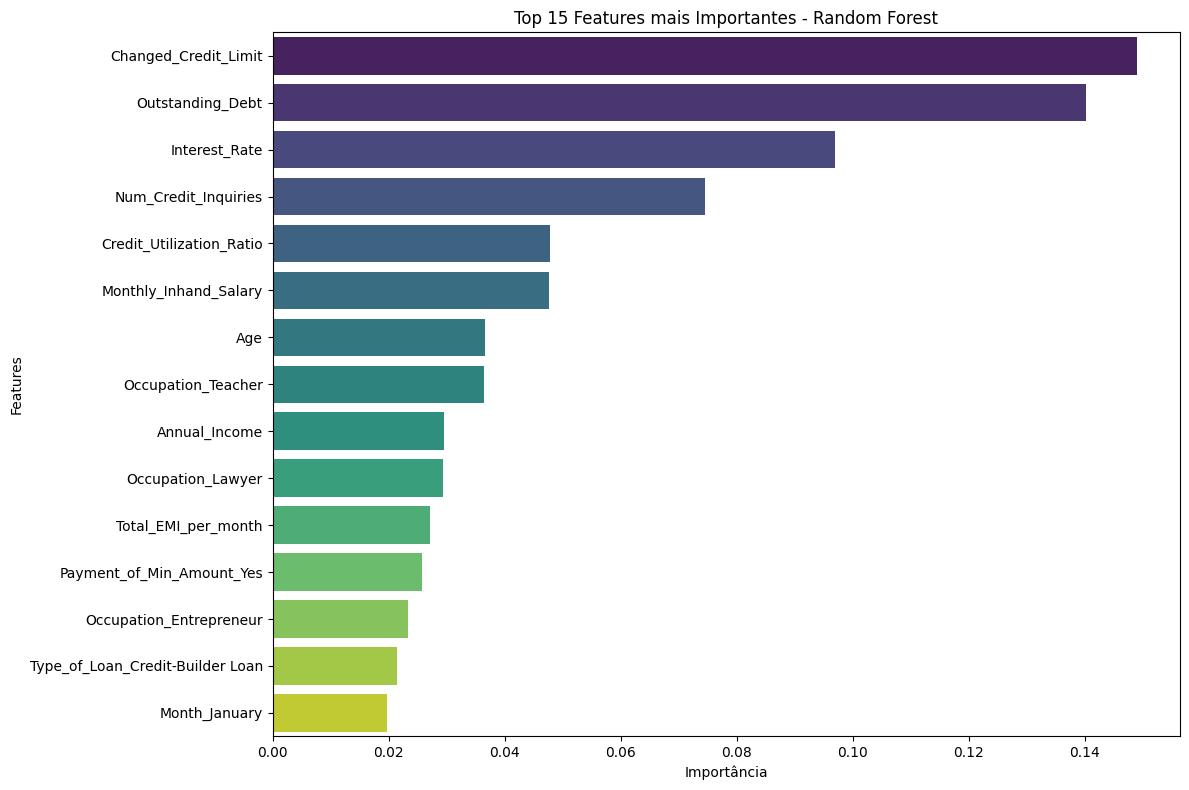

TOP 10 FEATURES MAIS IMPORTANTES
 1. Changed_Credit_Limit           0.1490
 2. Outstanding_Debt               0.1402
 3. Interest_Rate                  0.0970
 4. Num_Credit_Inquiries           0.0745
 5. Credit_Utilization_Ratio       0.0478
 6. Monthly_Inhand_Salary          0.0477
 7. Age                            0.0367
 8. Occupation_Teacher             0.0364
 9. Annual_Income                  0.0295
10. Occupation_Lawyer              0.0295


In [22]:
# Visualizando importância das features
import matplotlib.pyplot as plt
import seaborn as sns

# Obtendo importância das features do Random Forest
rf_model = final_model.named_steps['classifier']

# Obtendo nomes das features após o pré-processamento
feature_names = (numeric_features + 
                list(final_model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features)))

# Criando DataFrame com importâncias
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plotando as 15 features mais importantes
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Mostrando as 10 features mais importantes numericamente
print("TOP 10 FEATURES MAIS IMPORTANTES")
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} {row['importance']:.4f}")

# Visualizando matriz de confusão se temos dados de teste com target
if 'Credit_Score' in test_processed.columns:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_test, test_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), 
                yticklabels=np.unique(y_test))
    plt.title('Matriz de Confusão - Conjunto de Teste')
    plt.xlabel('Predições')
    plt.ylabel('Valores Reais')
    plt.tight_layout()
    plt.show()